In [1]:
# This file should put in the same directory of the program (a.out)
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from IPython.display import clear_output
plt.style.use(['science','no-latex'])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import the modules "estimator"
# import sys
# sys.path.append('../')
import estimator as es

In [4]:
# load the fiducial data
# ISS(LEO) dt=240, skiprows=40
# COSMOS-2468(LEO), MTCube(MEO), GALAXY-32(GEO) dt=60, skiprows=14

days=3
dt = 240
trange =np.arange(0,86400*days,dt) # be carefull with the time range in the .oem file
nrange = int(86400*days/dt)

with open('../data/ISS.oem', 'r') as file:
    data = file.readlines() # read a list of lines into data
    print(data[40]) #the initial statevector
stateVec0=np.loadtxt('../data/ISS.oem',skiprows = 40,usecols=(1,2,3,4,5,6),max_rows=nrange)*1000
altitude0 = np.array([es.altitude(stateVec0[i]) for i in range(len(stateVec0))])
print('Position:',stateVec0[0][0:3])
print('Velocity:',stateVec0[0][3:6])

2022-12-14T12:00:00.000 2524.798546369910 3547.480346098530 -5223.286743469080 -6.88150162273442 3.11385050390907 -1.21596824167983

Position: [ 2524798.54636991  3547480.34609853 -5223286.74346908]
Velocity: [-6881.50162273  3113.85050391 -1215.96824168]


In [5]:
# rewrite the configuration file in python interface 
# !!! notice the lines of parameters in configuration.dat file

# initial state
year   = 2022
month  = 12
day    = 14
hour  = 12
minute  = 0
second  = 0

pos0 = stateVec0[0][0:3]
vel0 = stateVec0[0][3:6]

mass = 472355.00      # mass of object in kg
Drag_area = 1457.20   # drag area in m^2
C_d = 2.00         # drag coefficient
Solar_area = 0.0   # area face to sun in m^2
geo_order = 2   # the order of geopotential

tfin   = 86400*days
stepsize = 10 # stepsize in s
nsteps   = 86400*days/stepsize 
schema = 'RK4' # SV or RK4


with open('./configuration.dat', 'r') as file:
    data = file.readlines() # read a list of lines into data
    
    # Initial state
    data[3]= 'year   = {}\n'.format(year)
    data[4]= 'month  = {}\n'.format(month)
    data[5]= 'day    = {}\n'.format(day) 
    data[6]= 'hour   = {}\n'.format(hour) 
    data[7]= 'minute = {}\n'.format(minute) 
    data[8]= 'second = {}\n'.format(second)
    data[10] = 'x01 = {} % position initiale en x [m]\n'.format(pos0[0])
    data[11] = 'y01 = {} % position initiale en y [m]\n'.format(pos0[1])
    data[12] = 'z01 = {} % position initiale en z [m]\n'.format(pos0[2])
    data[13] = 'vx01= {} % position initiale en x [m]\n'.format(vel0[0])
    data[14] = 'vy01= {} % position initiale en y [m]\n'.format(vel0[1])
    data[15] = 'vz01= {} % position initiale en z [m]\n'.format(vel0[2])

    # Physical parameters
    data[18] = 'mass1   = {}   % mass of obeject\n'.format(mass)
    data[19] = 'Drag_area = {} % surface of drag in m^2\n'.format(Drag_area)
    data[20] = 'C_d = {} % drag coeffiencient\n'.format(C_d)
    data[21] = 'Solar_area = {} % area face to sun in m^2\n'.format(Solar_area)
    data[22] = 'ordre = {} % geopotential order\n'.format(geo_order)
    
    # Integrator parameters
    data[25] = 'tfin   = {}  % simulation time in [s]\n'.format(tfin)
    data[26] = 'nsteps   = {} % nombre de pas de temps (dt=tfin/nsteps)\n'.format(nsteps)
    data[27] = 'schema   = {}  % Schema numerique RK4,SV\n'.format(schema)                                  
    
with open('./configuration.dat', 'w') as file:
    file.writelines(data)

	schema=RK4
	year=2022
	month=12
	day=14
	hour=12
	minute=0
	second=0
	x01=2.5248e+06
	y01=3.54748e+06
	z01=-5.22329e+06
	vx01=-6881.5
	vy01=3113.85
	vz01=-1215.97
	mass1=472355
	C_d=2
	Drag_area=1457.2
	Solar_area=0
	ordre=2
	tfin=259200
	nsteps=25920
	dr=0.04364
	dphi=1e-10
	sampling=1
	tol=0
	output=output.out
12 0 0 17 12 2022
1.74049


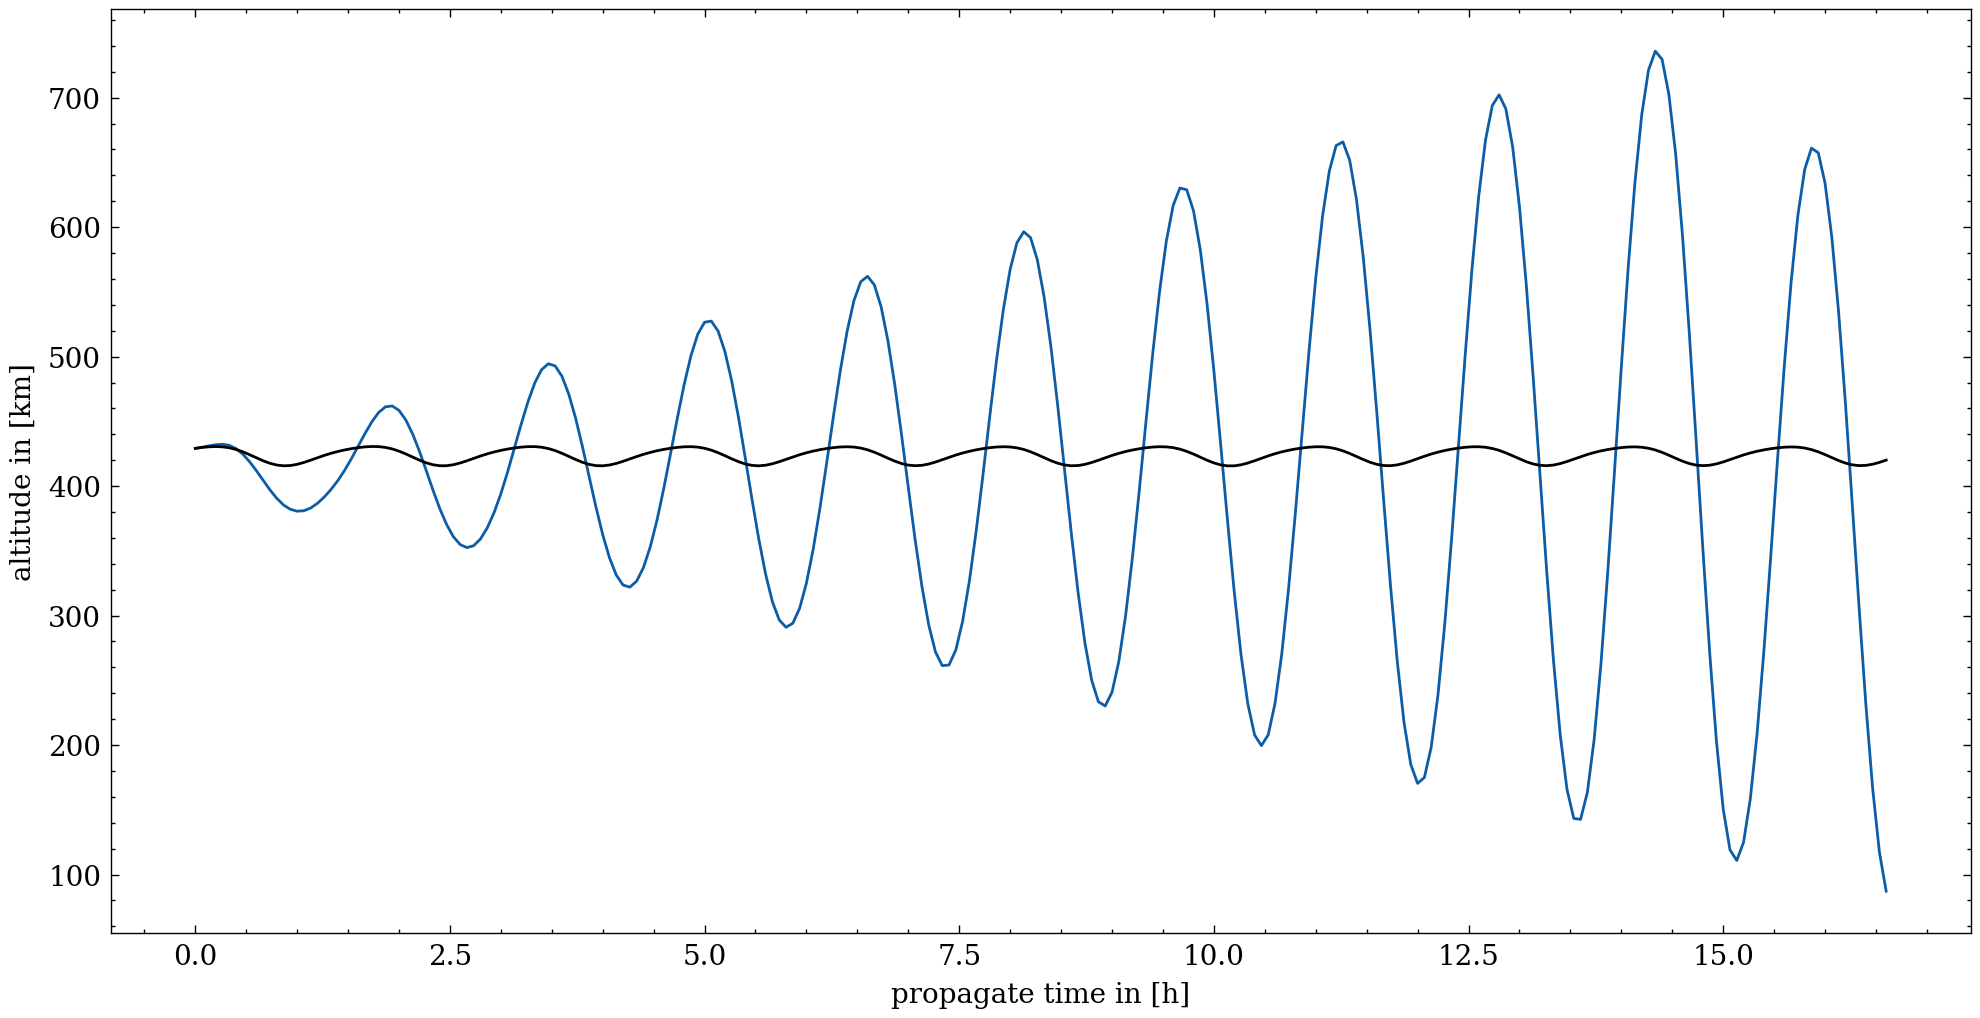

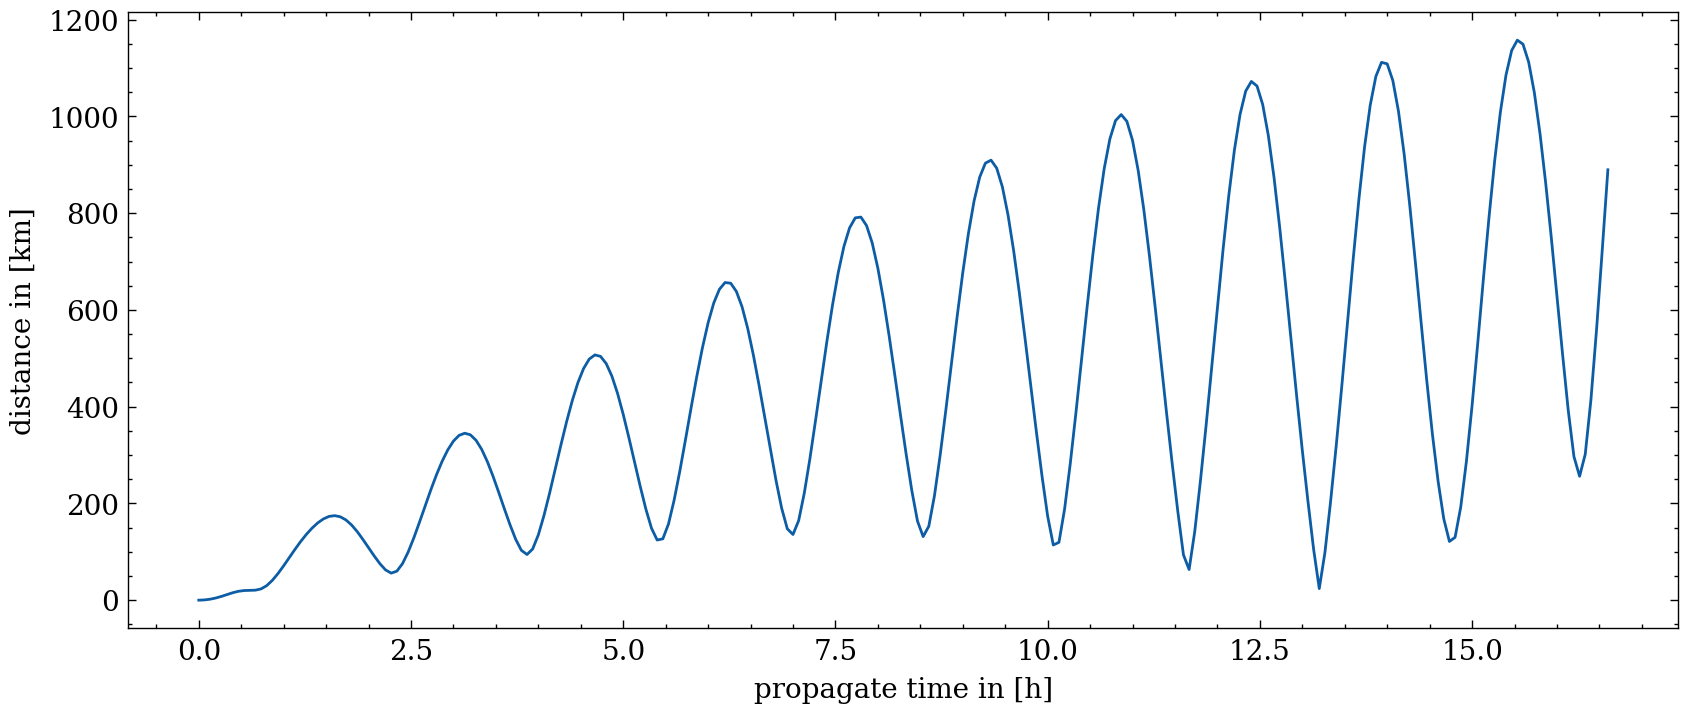

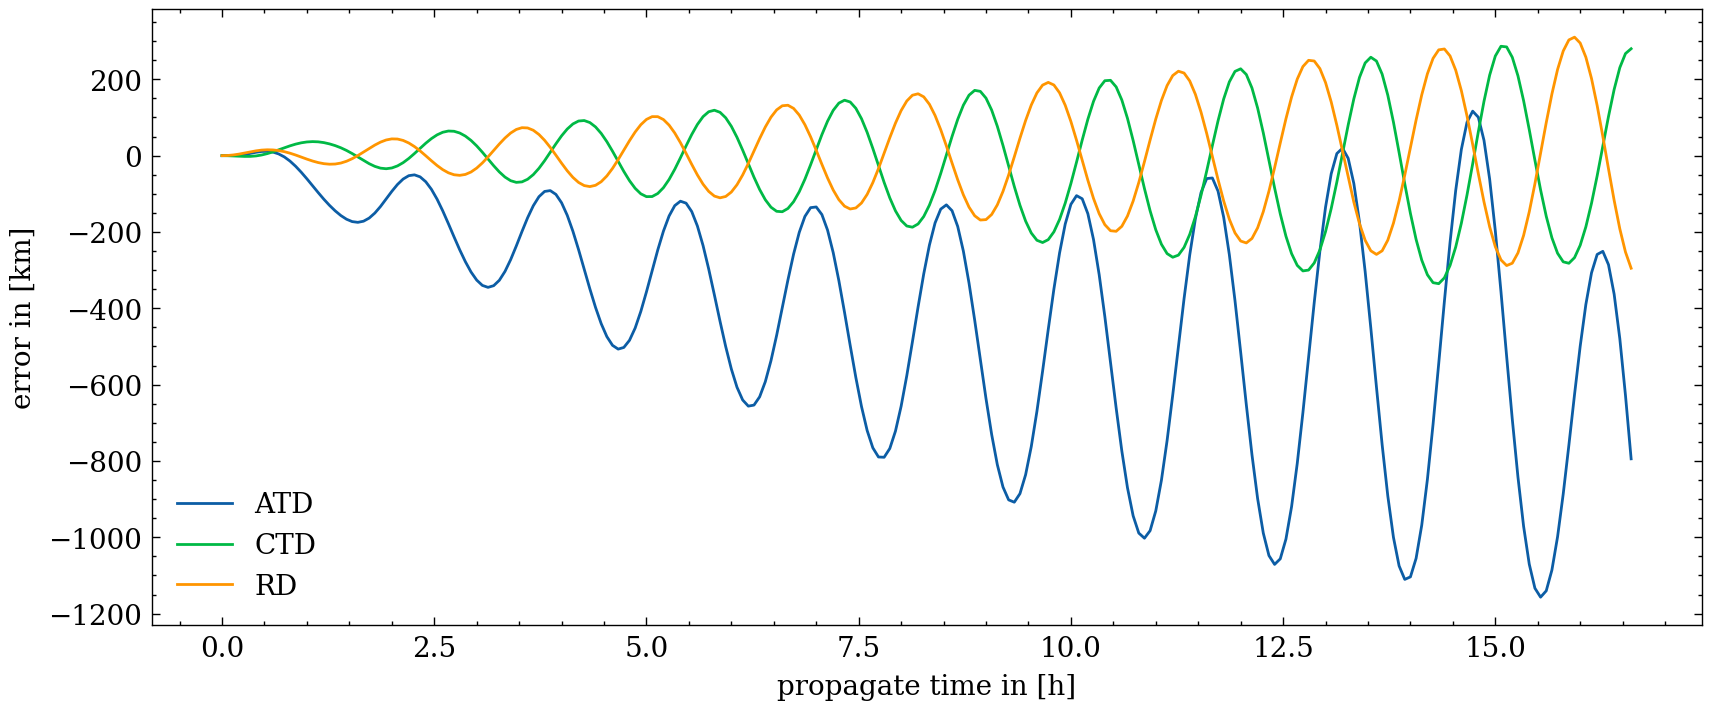

In [8]:
# run the program and plot the simulated data with fiducial one
main = './a.out'

if os.path.exists(main):
    output=os.system(main)

a=250

altitude0 = np.array([es.altitude(stateVec0[i]) for i in range(nrange)])

data = np.loadtxt('output.out',)
stateVec = es.dataCut(trange,data)

altitude = np.array([es.altitude(stateVec[i]) for i in range(nrange)])
distance = np.array([es.distance(stateVec[i],stateVec0[i]) for i in range(nrange)])

plt.figure(figsize=(12,6))
plt.plot(trange[0:a]/3600,(altitude[0:a])/1000)
plt.plot(trange[0:a]/3600,(altitude0[0:a])/1000,color='black')
plt.xlabel('propagate time in [h]')
plt.ylabel('altitude in [km]')

plt.figure(figsize=(10,4))
plt.plot(trange[0:a]/3600,distance[0:a]/1000)
plt.xlabel('propagate time in [h]')
plt.ylabel('distance in [km]')

error = [[],[],[]]
errortype = ['ATD','CTD','RD']
distance = []

for i in range(nrange):
    for n in range(3):
        error[n].append(es.errorEstimator(stateVec0[i],stateVec[i])[errortype[n]]/1000)
        
plt.figure(figsize=(10,4))

for n in range(3):
    plt.plot(trange[0:a]/3600,error[n][0:a],label=errortype[n])
    
plt.xlabel('propagate time in [h]')
plt.ylabel('error in [km]')
plt.legend(loc=3)
plt.show()

In [73]:
# run the program with different stepsize 

stepsizes = np.arange(10,80,1) # the range of stepsize
nsteps = 86400*days/stepsizes 
schemas=['SV','RK4']

error=[[],[]]
for i,s in enumerate(schemas):
    schema_line = 'schema   = {}  % Schema numerique RK4,SV\n'.format(s)
    with open('./configuration.dat', 'r') as file:
        data = file.readlines() # read a list of lines into data
        data[27]=schema_line # setting the schema (30nd line)
    with open('./configuration.dat', 'w') as file:
        file.writelines(data)

    for n in nsteps:
        nsteps_line = 'nsteps   = {} % nombre de pas de temps (dt=tfin/nsteps)\n'.format(n)
        with open('./configuration.dat', 'r') as file:
            data = file.readlines()# read a list of lines into data
            data[26]=nsteps_line # setting the number of steps (30nd line)
        with open('./configuration.dat', 'w') as file:
            file.writelines(data)
        if os.path.exists(main):
            output=os.system(main)
        data = np.loadtxt(r'./output.out')
        stateVec = es.dataCut(trange,data)
#         altitude = np.array([es.altitude(stateVec[i]) for i in range(len(stateVec))]) 
        distance = [es.distance(stateVec[i],stateVec0[i]) for i in range(nrange)] 
    
        error[i].append(np.mean(distance)/1000)

	schema=SV
	year=2022
	month=12
	day=14
	hour=12
	minute=0
	second=0
	x01=2.5248e+06
	y01=3.54748e+06
	z01=-5.22329e+06
	vx01=-6881.5
	vy01=3113.85
	vz01=-1215.97
	mass1=472355
	C_d=2
	Drag_area=1457.2
	Solar_area=0
	ordre=0
	tfin=259200
	nsteps=43200
	dr=0.04364
	dphi=0.001
	sampling=1
	tol=0
	output=output.out
12 0 0 17 12 20220160
3.29733
	schema=SV
	year=2022
	month=12
	day=14
	hour=12
	minute=0
	second=0
	x01=2.5248e+06
	y01=3.54748e+06
	z01=-5.22329e+06
	vx01=-6881.5
	vy01=3113.85
	vz01=-1215.97
	mass1=472355
	C_d=2
	Drag_area=1457.2
	Solar_area=0
	ordre=0
	tfin=259200
	nsteps=32400
	dr=0.04364
	dphi=0.001
	sampling=1
	tol=0
	output=output.out
12 0 0 17 12 2022
2.38826
	schema=SV
	year=2022
	month=12
	day=14
	hour=12
	minute=0
	second=0
	x01=2.5248e+06
	y01=3.54748e+06
	z01=-5.22329e+06
	vx01=-6881.5
	vy01=3113.85
	vz01=-1215.97
	mass1=472355
	C_d=2
	Drag_area=1457.2
	Solar_area=0
	ordre=0
	tfin=259200
	nsteps=25920
	dr=0.04364
	dphi=0.001
	sampling=1
	tol=0
	output=output.out
12

11 59 60 17 12 2022
0.558261
	schema=RK4
	year=2022
	month=12
	day=14
	hour=12
	minute=0
	second=0
	x01=2.5248e+06
	y01=3.54748e+06
	z01=-5.22329e+06
	vx01=-6881.5
	vy01=3113.85
	vz01=-1215.97
	mass1=472355
	C_d=2
	Drag_area=1457.2
	Solar_area=0
	ordre=0
	tfin=259200
	nsteps=3410
	dr=0.04364
	dphi=0.001
	sampling=1
	tol=0
	output=output.out
12 0 1.37523e-08 17 12 2022
0.344584
	schema=RK4
	year=2022
	month=12
	day=14
	hour=12
	minute=0
	second=0
	x01=2.5248e+06
	y01=3.54748e+06
	z01=-5.22329e+06
	vx01=-6881.5
	vy01=3113.85
	vz01=-1215.97
	mass1=472355
	C_d=2
	Drag_area=1457.2
	Solar_area=0
	ordre=0
	tfin=259200
	nsteps=3323
	dr=0.04364
	dphi=0.001
	sampling=1
	tol=0
	output=output.out
11 59 60 17 12 2022
0.356215


Best stepsize:
SV: 48
RK4: 14


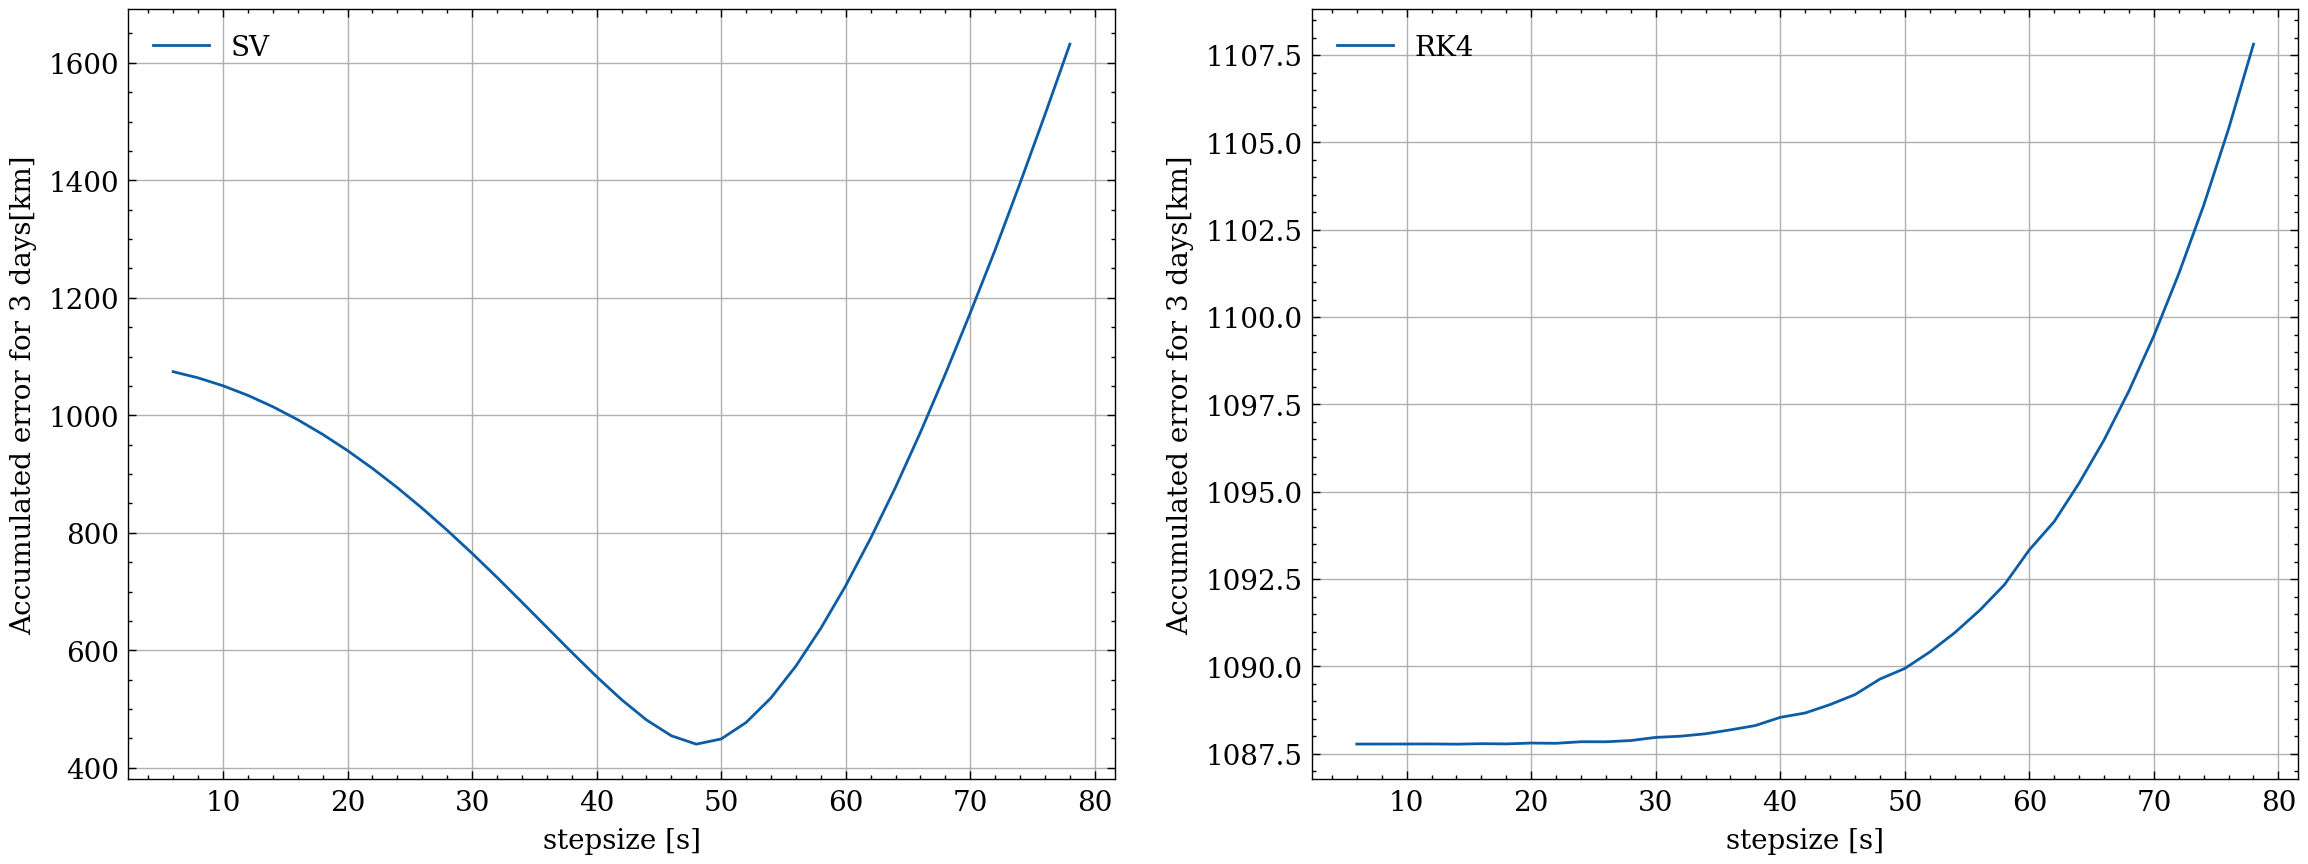

In [74]:
best_step=[0,0]
plt.figure(figsize=(14,5))

print('Best stepsize:')
for i in range(2):
    plt.subplot(1, 2, i+1)
    best_step[i]=stepsizes[np.argmin(error[i])]
    plt.plot(stepsizes,error[i],label='{}'.format(schemas[i]))
    plt.xlabel('stepsize [s]')
    plt.ylabel('Accumulated error for 3 days[km]')
    plt.legend()
    plt.grid(1)
    print('{}:'.format(schemas[i]),best_step[i])